In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 5                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD          

In [3]:

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

val20_epochs5


In [4]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last')

train_data_gen = train_dr.flow_from_directory(directory="AlzheimerDataset/train/",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="AlzheimerDataset/test/",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled t

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()


In [6]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [7]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

In [8]:
# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)
print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


In [9]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


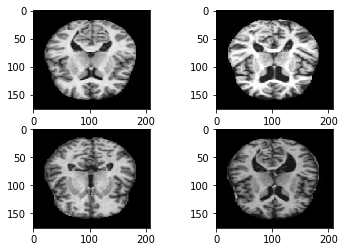

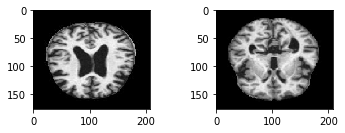

In [10]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [11]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


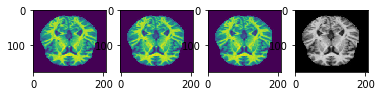

In [12]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [ ]:

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked




## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()


In [ ]:
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

vg_model.save_weights(save_model_name + ".h5")

Epoch 1/5
220/220 [==============================] - 3601s 16s/step - loss: 0.7793 - accuracy: 0.6537 - val_loss: 0.7793 - val_accuracy: 0.6656
Epoch 2/5
194/220 [=========================>....] - ETA: 7:24 - loss: 0.6893 - accuracy: 0.6987

In [18]:
tf.config.experimental.list_physical_devices('GPU') 

[]

In [ ]:
vg_model.load_weights('val20_epochs5.h5')